# **GTSF IC Quant Mentorship - Intro Project**

Project Idea: The basic idea for my final project is to explore how **inflation** affects **discretionary** (non-essential) versus **non-discretionary** (essential) goods and services.
My initial hypothesis is that high inflation rates will cause consumer staples stocks to become less volatile and consumer discretionary stocks to become more volatile. This is because consumers will cut down on non-essential costs during periods of rising prices in order to prioritize necessities. Also, I hypothesize that consumer staples stocks are GENERALLY less volatile than discretionary stocks because consumers will consistently need to buy essential goods and services.

This hypothesis could be used for a trading strategy where a portfolio is weighted more towards **consumer discretionary stocks** during periods of **low or stable inflation**, prioritizing capital growth. On the other hand, during periods of **fast rising inflation**, the strategy shifts toward **consumer staples stocks**, prioritizing stability. Lastly, during periods of **deflation**, which signify recessions or weak consumer demand, the portfolio can continue to be weighted towards **consumer staples stocks** to maintain stability.

Signal and Data Collection: The main signal we are looking at is **inflation**, which is represented by the **Consumer Price Index (CPI)**. We can gather time-series data for this from **Federal Reserve Economic Data (FRED)**. Furthermore, we are also looking at how this signal affects consumer discretionary vs staples. To categorize specific types of consumer spending, we will use exchange traded funds (ETFs) as representations for the two categories. Specifically, **XLY** represents consumer discretionary while **XLP** represents consumer staples.


## Step 1: Install necessary dependencies

In [297]:
from calendar import month
! pip install pandas matplotlib yfinance fredapi scikit-learn statsmodels pandas-datareader

## Step 2: Import necessary dependencies

In [298]:
import pandas as pd
import numpy as np
import yfinance as yf
from pandas_datareader import data as pdr
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

## Step 3: Data Cleaning and Preprocessing

In [299]:
def import_stock_data(start: datetime.datetime, end: datetime.datetime) -> pd.DataFrame:
    cpi = pdr.DataReader('CPIAUCNS', 'fred', start, end)
    cpi = cpi.ffill()
    
    xlp = yf.download('XLP', start=start, end=end)['Close']['XLP']
    xly = yf.download('XLY', start=start, end=end)['Close']['XLY']
    
    xlp = xlp.ffill()
    xly = xly.ffill()
    
    xlp_returns = xlp.pct_change().ffill().fillna(0)
    xly_returns = xly.pct_change().ffill().fillna(0)
    cpi_change = cpi.pct_change().ffill().fillna(0)
    
    df = pd.concat([xlp, xly, xlp_returns, xly_returns, cpi_change], axis=1)
    df.columns = ['XLP', 'XLY', 'XLP_Return', 'XLY_Return', 'CPI_Change']
    
    # since CPI data is monthly, align CPI monthly value to the rest of the days in the month
    df['CPI_Change'] = df['CPI_Change'].ffill()
    
    # add volatility info for ETFs
    # 21-day rolling volatility (1 trading month)
    df['XLP_Volatility'] = df['XLP_Return'].rolling(window=21).std()
    df['XLY_Volatility'] = df['XLY_Return'].rolling(window=21).std()

    
    df.dropna(inplace=True)
    df[['XLP_Return_Z', 'XLY_Return_Z', 'CPI_Change_Z']] = df[['XLP_Return', 'XLY_Return', 'CPI_Change']].apply(
        lambda x: (x - x.mean()) / x.std()
    )
    
    return df

#############
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2024, 12, 31)
df = import_stock_data(start, end)
print(df.head())
#############

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

                  XLP        XLY  XLP_Return  XLY_Return  CPI_Change  \
2010-02-02  17.800951  24.555422    0.014394    0.014003    0.000249   
2010-02-03  17.674654  24.571960   -0.007095    0.000674    0.000249   
2010-02-04  17.315702  23.860683   -0.020309   -0.028947    0.000249   
2010-02-05  17.269175  23.794521   -0.002687   -0.002773    0.000249   
2010-02-08  17.249239  23.645653   -0.001154   -0.006256    0.000249   

            XLP_Volatility  XLY_Volatility  XLP_Return_Z  XLY_Return_Z  \
2010-02-02        0.006031        0.009570      1.772414      1.097938   
2010-02-03        0.006239        0.009572     -0.979462     -0.005173   
2010-02-04        0.007633        0.011356     -2.671643     -2.456487   
2010-02-05        0.007640        0.011332     -0.414979     -0.290389   
2010-02-08        0.007635        0.011103     -0.218709     -0.578683   

            CPI_Change_Z  
2010-02-02     -0.527688  
2010-02-03     -0.527688  
2010-02-04     -0.527688  
2010-02-05    

## Step 4: Plot CPI, XLP, XLY (Graph 1)

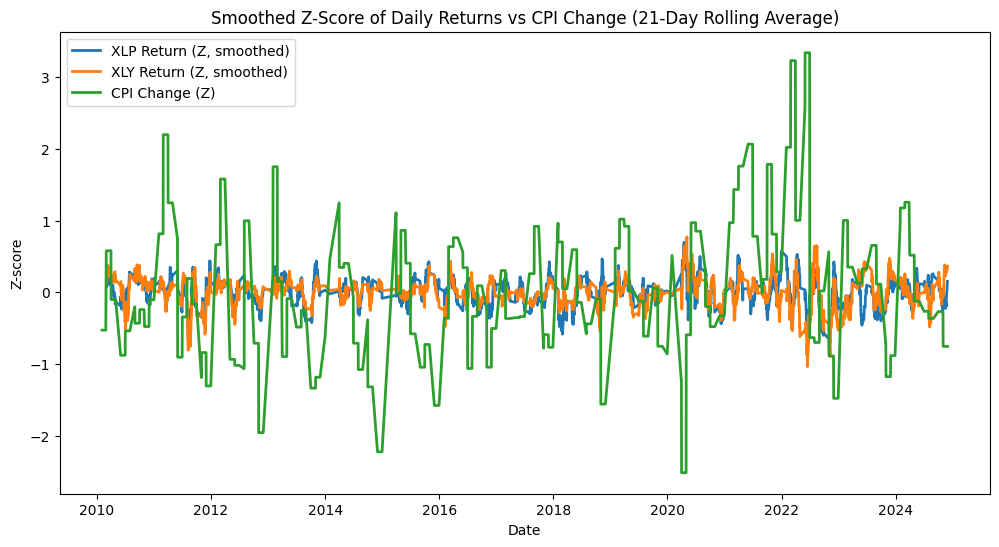

In [300]:
# Apply rolling mean to smooth daily data and make graph more readable

def smoothCol(df: pd.DataFrame, col: str, window: int) -> pd.DataFrame:
    df[col + '_Smooth'] = df[col].rolling(window=window).mean()
    return df

# smooth data
roll_window = 21 # usual length of 1 trading month
df = smoothCol(df, 'XLP_Return_Z', roll_window)
df = smoothCol(df, 'XLY_Return_Z', roll_window)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['XLP_Return_Z_Smooth'], label='XLP Return (Z, smoothed)', linewidth=2)
plt.plot(df.index, df['XLY_Return_Z_Smooth'], label='XLY Return (Z, smoothed)', linewidth=2)
plt.plot(df.index, df['CPI_Change_Z'], label='CPI Change (Z)', linewidth=2)
plt.title('Smoothed Z-Score of Daily Returns vs CPI Change (21-Day Rolling Average)')
plt.xlabel('Date')
plt.ylabel('Z-score')
plt.legend()
plt.show()

## Step 5: Plot 21-Day Rolling Volatility and CPI Change

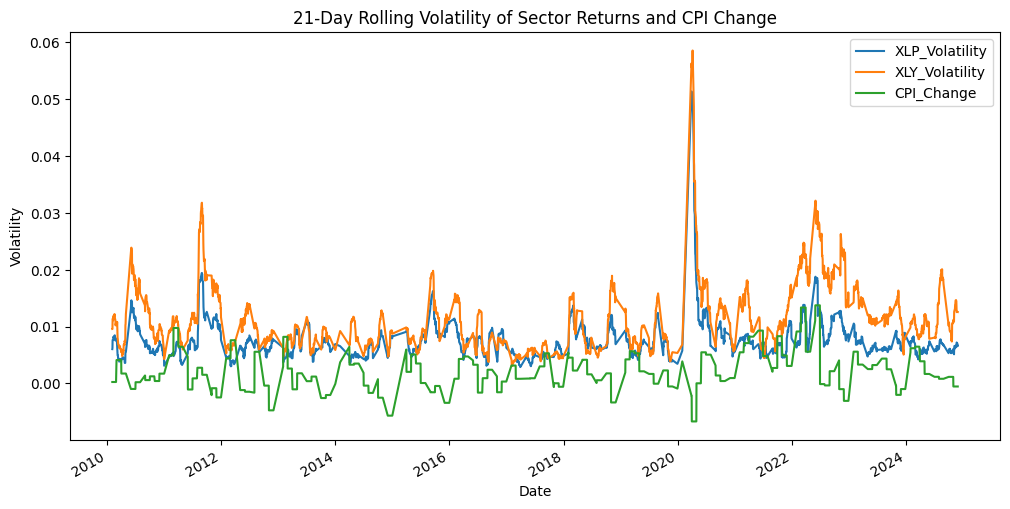

In [301]:
# plot XLP/XLY volatilities and CPI change
df[['XLP_Volatility', 'XLY_Volatility', 'CPI_Change']].plot(
    figsize=(12, 6), title='21-Day Rolling Volatility of Sector Returns and CPI Change')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.show()

## Step 6: Compare High vs Low Inflation

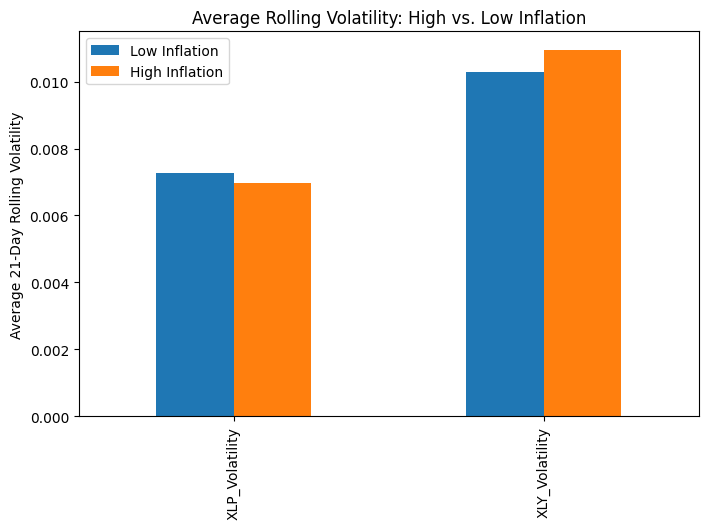

In [302]:
# Define high vs. low inflation "regimes" based on monthly CPI change being above or below all time inflation median
def highVsLowDf(df: pd.DataFrame) -> pd.DataFrame:
    # Since we are only looking at inflation rather than deflation, we are only focusing on instances where CPI is INCREASING (CPI rate is > 0)
    median_inflation_cpi = df[df['CPI_Change'] > 0]['CPI_Change'].median()
    high_inflation = df[df['CPI_Change'] > median_inflation_cpi]
    low_inflation = df[(df['CPI_Change'] > 0) & (df['CPI_Change'] < median_inflation_cpi)]
    
    # Compare average rolling volatility in each regime
    vol_high = high_inflation[['XLP_Volatility', 'XLY_Volatility']].mean()
    vol_low = low_inflation[['XLP_Volatility', 'XLY_Volatility']].mean()
    return pd.DataFrame({'Low Inflation': vol_low, 'High Inflation': vol_high})

# Plot
highVsLowDf(df).plot(
    kind='bar', figsize=(8, 5), title='Average Rolling Volatility: High vs. Low Inflation')
plt.ylabel('Average 21-Day Rolling Volatility')
plt.show()

This graph is **supports** our hypothesis because XLP (the consumer staples ETF) become LESS volatile during periods of high inflation while XLY (the consumer discretionary ETF) becomes MORE volatile during periods of high inflation. Furthermore, the graph also supports the second part of our hypothesis because the XLP ETF is generally LESS volatile than the XLY ETF.  

## Step 7: Analyze Correlation between XLP-XLY Difference in Volatility and Increases in CPI

Based on previous data and our hypothesis, there must be negative correlation between the XLP-XLY Difference in Volatility and CPI Inflation Rates because during periods of high inflation, consumer discretionary stocks (XLY) experience greater volatility due to uncertainty in non-essential spending, while consumer staples (XLP) remain relatively stable.

In [303]:
def inflationDf(df: pd.DataFrame) -> pd.DataFrame:
    return df[df['CPI_Change'] > 0] # only look at rows where cpi is increasing (cpi rate is pos)

def volVsCPICorr(df: pd.DataFrame) -> int:
    df['XLP_minus_XLY_Vol'] = df['XLP_Volatility'] - df['XLY_Volatility']
    
    corr_pos = inflationDf(df)['XLP_minus_XLY_Vol'].corr(inflationDf(df)['CPI_Change'])
    return corr_pos

print(f"Correlation (XLP - XLY) vs CPI during inflation only: {volVsCPICorr(df):.4f}")



Correlation (XLP - XLY) vs CPI during inflation only: -0.3394


## Step 8: Correlation between XLP-XLY Price Difference and CPI

In [304]:
def monthlyPctDiff(df: pd.DataFrame) -> pd.DataFrame:
    xlp_monthly = df['XLP'].resample('MS').last()
    xly_monthly = df['XLY'].resample('MS').last()
    
    xlp_monthly_ret = xlp_monthly.pct_change(fill_method = None).fillna(0)
    xly_monthly_ret = xly_monthly.pct_change(fill_method = None).fillna(0)
    
    monthly_pct_diff = xlp_monthly_ret - xly_monthly_ret
    
    monthly_pct_diff.name = 'XLP_minus_XLY'
    return monthly_pct_diff

monthly_diff = monthlyPctDiff(df)
corr = monthly_diff.corr(inflationDf(df)['CPI_Change'])
print(f"Correlation between Monthly Price Diff and CPI: {corr:.4f}")

Correlation between Monthly Price Diff and CPI: 0.0726


We hypothesized originally that inflation (CPI increases) would drive the outperformance of consumer staples (XLP) over discretionary stocks (XLY). The monthly return difference between XLP and XLY showed a positive correlation with CPI (+0.0726), but the relationship was weak. This suggests that while inflation may contribute to investor sector preference, it is not necessarily the only main factor involved. Therefore, we can use PCA analysis to find more factors that influence the relationship between XLP and XLY.

## Step 9: PCA and Statistical Modeling/Forecasting

In [305]:
# Apply PCA to 3 macro factors

def createMacroPCA(macro_codes: dict[str, str]) -> pd.DataFrame:   
    macro = pd.DataFrame()
    for name, code in macro_codes.items():
        macro[name] = pdr.DataReader(code, 'fred', start, end)
    
    # monthly percent change 
    macro = macro.pct_change().abs().dropna()
    
    # Standardize macro data
    scaler = StandardScaler()
    macro_scaled = scaler.fit_transform(macro)
    
    # Apply PCA (1 component)
    pca = PCA(n_components=1)
    macro['PC1'] = pca.fit_transform(macro_scaled)
    
    return macro

macro_codes = {
        'CPI': 'CPIAUCNS',
        'Unemployment': 'UNRATE',
        'Retail_Sales': 'RSAFS'
}

# For OLS Model
macro = createMacroPCA(macro_codes)
monthly_model_df = pd.concat([monthly_diff, macro['PC1']], axis=1).dropna()
monthly_model_df.columns = ['XLP_minus_XLY', 'PC1']

# For RandomForestRegressor Model
features = ['CPI', 'Unemployment', 'Retail_Sales']
target = 'XLP_minus_XLY'
monthly_model_df_rfr = pd.concat([monthly_diff, macro[features]], axis=1).dropna()

# Use 80% of the data for training, 20% for testing
split_index = int(len(monthly_model_df) * 0.8)

train = monthly_model_df.iloc[:split_index]
test = monthly_model_df.iloc[split_index:]

print(monthly_model_df)

            XLP_minus_XLY       PC1
2010-02-01       0.000000 -0.722851
2010-03-01      -0.040394  0.366931
2010-04-01      -0.071034 -0.335901
2010-05-01       0.000000 -0.329484
2010-06-01       0.000000 -0.600199
...                   ...       ...
2024-07-01       0.000000 -0.213881
2024-08-01       0.061832 -0.699086
2024-09-01       0.000000 -0.267205
2024-10-01       0.000000 -0.517182
2024-11-01      -0.090365 -0.465279

[178 rows x 2 columns]


In [306]:
# For OLS

# TRAIN
X_train = sm.add_constant(train['PC1'])
y_train = train['XLP_minus_XLY']

# TEST
X_test = sm.add_constant(test['PC1'])
y_test = test['XLP_minus_XLY']

model_OLS = sm.OLS(y_train, X_train).fit()
print(model_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:          XLP_minus_XLY   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     17.73
Date:                Sun, 20 Apr 2025   Prob (F-statistic):           4.53e-05
Time:                        22:33:56   Log-Likelihood:                 319.11
No. Observations:                 142   AIC:                            -634.2
Df Residuals:                     140   BIC:                            -628.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0066      0.002     -3.056      0.0

Our OLS-based model shows that broad macroeconomic shifts, summarized by PC1 (based on CPI, Unemployment, and Retail Sales), have a statistically significant effect on monthly price difference between consumer staples (XLP) and discretionary stocks (XLY). A one standard deviation increase in PC1 is associated with a -0.65% increase in the XLP–XLY monthly return difference (p = 0.025).

In [307]:
# RFR Model
split_index = int(len(monthly_model_df_rfr) * 0.8)
train_rfr = monthly_model_df_rfr.iloc[:split_index]
test_rfr = monthly_model_df_rfr.iloc[split_index:]

# TRAIN
X_train_rfr = train_rfr[features]
y_train_rfr = train_rfr[target]

# TEST
X_test_rfr = test_rfr[features]
y_test_rfr = test_rfr[target]

rf_model = RandomForestRegressor(
    n_estimators=150, 
    max_depth=5, 
    random_state=40
)
rf_model.fit(X_train_rfr, y_train_rfr)

RandomForestRegressor(max_depth=5, n_estimators=150, random_state=40)

## Step 10: Model Evaluation

### OLS Model Eval

In [308]:
# Predict on test set
y_pred_test = model_OLS.predict(X_test)

# Metrics
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)

print(f"Test RMSE: {rmse_test:.4f}")
print(f"Test MAE: {mae_test:.4f}")

Test RMSE: 0.0590
Test MAE: 0.0422


### RandomForestRegressor Model Eval

In [309]:
y_pred_rfr = rf_model.predict(X_test_rfr)

rmse = np.sqrt(mean_squared_error(y_test_rfr, y_pred_rfr))
mae = mean_absolute_error(y_test_rfr, y_pred_rfr)
r2 = r2_score(y_test_rfr, y_pred_rfr)

print(f"Random Forest Test RMSE: {rmse:.4f}")
print(f"Random Forest Test MAE : {mae:.4f}")
print(f"Random Forest Test R^2  : {r2:.4f}")

Random Forest Test RMSE: 0.0587
Random Forest Test MAE : 0.0416
Random Forest Test R^2  : -0.0879


### Graph of Model Predictions (OLS)

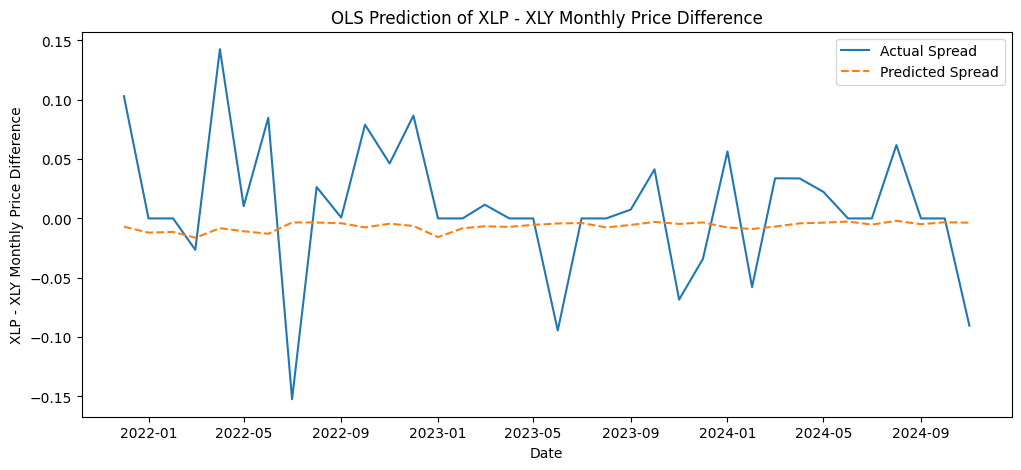

In [313]:
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test, label='Actual Spread')
plt.plot(y_test.index, y_pred_test, label='Predicted Spread', linestyle='--')
plt.title('OLS Prediction of XLP - XLY Monthly Price Difference')
plt.ylabel('XLP - XLY Monthly Price Difference')
plt.xlabel('Date')
plt.legend()
plt.show()

### Graph of Model Predictions (RandomForestRegressor)

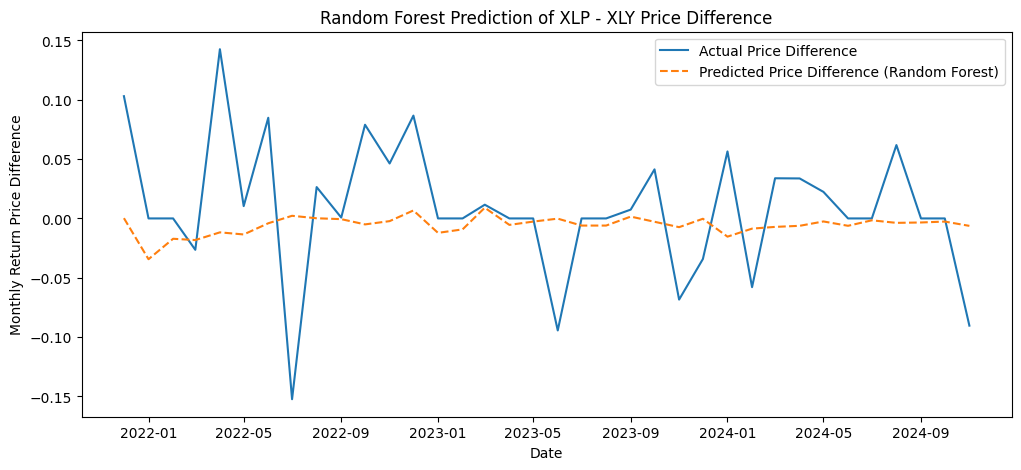

In [312]:
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test_rfr, label='Actual Price Difference')
plt.plot(y_test.index, y_pred_rfr, label='Predicted Price Difference (Random Forest)', linestyle='--')
plt.title('Random Forest Prediction of XLP - XLY Price Difference')
plt.ylabel('Monthly Return Price Difference')
plt.xlabel('Date')
plt.legend()
plt.show()

We modeled the monthly return difference between consumer staples (XLP) and consumer discretionary (XLY) using both linear and non-linear approaches. The **OLS** regression, using a 1 component PCA of CPI, Unemployment, and Retail Sales, found PC1 to be statistically significant **(p = 0.025)** but only explained 11.2% of the variation in the spread **(R^2 = 0.112)**, indicating **limited prediction ability**. 

That is why I also tried the **Random Forest Regressor** (RFR): in order to capture non-linear relationships. However, the RFR model performed worse in testing, with a **negative R^2 (−0.087)**, suggesting it underfit the data and performed worse than predicting the mean. Both models struggled to capture the volatility and complexity of sector return spreads, highlighting the difficulty of using macro variables alone to predict short-term market behavior. These results suggest that while macro conditions may influence sector trends, more complex or domain-specific signals may be needed for reliable forecasting. 

**However, weighting a portfolio of discretionary and staples consumer stocks based on CPI rates could still be a viable trading strategy**. 